# Logistic regression exampple

In [17]:
import os
import pandas as pd #Data manipulation
import numpy as np #Data manipulation
import matplotlib.pyplot as plt # Visualization
import seaborn as sns #Visualization
plt.rcParams['figure.figsize'] = [8,5]
plt.rcParams['font.size'] =14
plt.rcParams['font.weight']= 'bold'
plt.style.use('seaborn-whitegrid')

We will try out logistic regression to predict if a car purchase will happen or not, depending on some characteristics from the customers: We will be using gender, age and salary to try to predict whether a car will be purchased or not.

Let's start by loading our data:

In [18]:
# Load data
df_raw = pd.read_csv('../input/cars-purchase-decision-dataset/car_data.csv')
df_raw.head()

,User ID,Gender,Age,AnnualSalary,Purchased
0,385,Male,35,20000,0
1,681,Male,40,43500,0
2,353,Male,49,74000,0
3,895,Male,40,107500,1
4,661,Male,25,79000,0


## Data exploration



Before creating any visualizations we need to identify if our target variable is **balanced**, i.e. if we have a similar number of observations for each of our target classifications:

In [19]:
print(df_raw['Purchased'].value_counts())

0    598
1    402
Name: Purchased, dtype: int64


It seems like we don't have a similar number of observations. If we didn't, then we'd have to check for some augmentation techniques like SMOTE or ROSE.
This is particularly important because it is related to our base predictor, which is basically "predicting" every single observation to be the same, e.g. all value for [Purchased] = 1, i.e our predictor is "everybody is going to purchase a car".

We can calculate our accuracy as succesfull classifications, which in this case is only how many 1s we can correctly identify:

$\frac{1}{n}\sum 1_{\{y = 1\}}$

On the other hand we mighyt have a "pesimistic" predictor where we predict for all observations that noone is buying a car:

$\frac{1}{n}\sum 1_{\{y = 0\}}$

In [20]:
print('Optimistic predictor accuracy: {:.0%}'.format(np.mean(df_raw['Purchased'] == 1)))
print('Pesimistic predictor accuracy: {:.0%}'.format(np.mean(df_raw['Purchased'] == 0)))

Optimistic predictor accuracy: 40%
Pesimistic predictor accuracy: 60%


Let's continue with some visualizations:

Text(0.5, 1.0, 'Violin plot of Age vs Purchased')

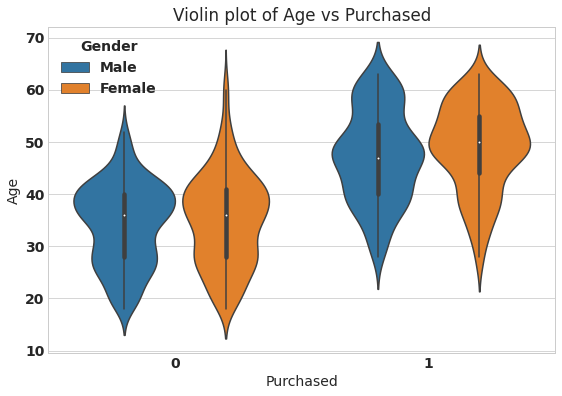

In [21]:
f = plt.figure(figsize=(20,6))
ax = f.add_subplot(121)
sns.violinplot(x='Purchased', y='Age',hue = 'Gender',data=df_raw,ax=ax)
ax.set_title('Violin plot of Age vs Purchased')

Text(0.5, 1.0, 'Violin plot of AnnualSalary vs Purchased')

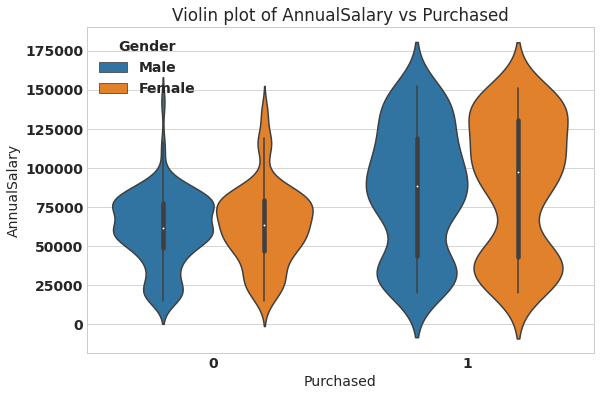

In [22]:
f = plt.figure(figsize=(20,6))
ax = f.add_subplot(121)
sns.violinplot(x='Purchased', y='AnnualSalary',hue = 'Gender',data=df_raw,ax=ax)
ax.set_title('Violin plot of AnnualSalary vs Purchased')

There's definitively a clear bias towards higher values in Salaries that result in a purchase.

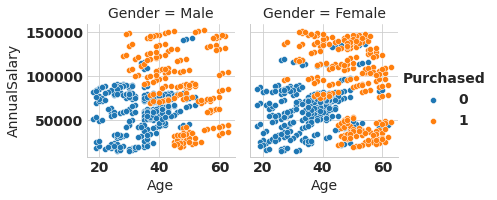

In [23]:
g = sns.FacetGrid(df_raw, col="Gender", hue="Purchased")
g.map(sns.scatterplot, "Age", "AnnualSalary")
g.add_legend()

Finally, there doesn't semm to be too much of an effect based on Gender, but we'll include it as well in case there's some significant effect we can capture mathematically.

## Model fitting

We will now fit our model. As usual, we'll encode our categorical variables, include interaction terms, and split our dataset into test/validation.

In [24]:
# Split data into training and test set
from sklearn.model_selection import train_test_split
X = df_raw.drop('Purchased',axis=1) # Independet variable
y = df_raw['Purchased'] # dependent variable

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=23)

# model variables
mod_features = ['Gender','Age','AnnualSalary']
X_train = X_train.loc[:,mod_features]
X_test = X_test.loc[:,mod_features]

In [25]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

OHE = OneHotEncoder()
scaler = StandardScaler()
logreg = LogisticRegression(random_state = 16)

cat_cols = ['Gender']
num_cols = ['Age','AnnualSalary']

transformer = ColumnTransformer([('cat_cols', OHE, cat_cols),
                                ('num_cols', scaler, num_cols)])

pipe = Pipeline([("preprocessing", transformer),
                ("classifier", logreg)])

pipe.fit(X_train,y_train)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('cat_cols', OneHotEncoder(),
                                                  ['Gender']),
                                                 ('num_cols', StandardScaler(),
                                                  ['Age', 'AnnualSalary'])])),
                ('classifier', LogisticRegression(random_state=16))])

In [35]:
y_pred = pipe.predict(X_test)
acc1 = 1-np.mean(np.abs(y_test - y_pred))

print('Naive pesimistic model accuracy: {:.0%}'.format(np.mean(y_pred == 0)))
print('Base model accuracy: {:.0%}'.format(acc1))

Naive pesimistic model accuracy: 64%
Base model accuracy: 85%


So our base model has a 21% improvement over our naive "pesimistic" model, which was 60%. We'd actually want to investigate how well our model does _given_ that an observation is of a particular classification. In practice, this is of great interest where there's an associated cost (be it effort or money) to misclassiffying an observation, be it because it's too expensive not to classify a negative such (type 1 error), or not classifying a positive observation as such (type 2 error). Here's where it's important to assess your problem in the context of your business knowledge and taking into consideration the important concept of ROC curve, which we'll consider next.

## ROC curve
The ROC curve allows us to take into consideration the **sensitivity** and **specificity** of a model. The first one refers to _the number of positive observations your model identified correctly_, whereas the second one refers to _the number of negative observations your model identified correctly_. With the ROC curve you can assess both metrics as you move your threshold, so that your model becomes more strict when identifying observations as either positive or negative. The final goal is to achieve a balance between the two.

In [33]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[162,  15],
       [ 30,  93]])

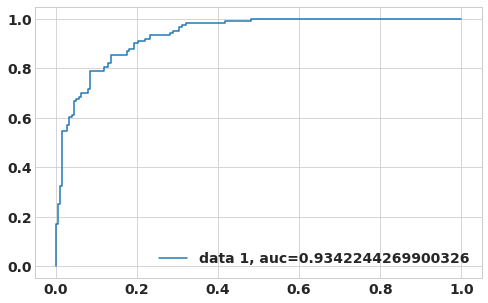

In [31]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

y_pred_proba = pipe.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()